<a href="https://colab.research.google.com/github/sudhanshumukherjeexx/PyTorch-Playground/blob/main/3_Image_Classification_FeedForward%2C_CNN%2C_and_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
from torchvision import models


### 2. Loading and Preprocessing the CIFAR-10 Dataset

In [2]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
])

- Load CIFAR-10 dataset

In [3]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

100%|██████████| 170498071/170498071 [00:02<00:00, 81180436.84it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


- CIFAR-10 class names

In [4]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(f'Classes: {classes}')

Classes: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


## Simple FeedForward Neural Network

In [5]:
class SimpleFeedForwardNN(nn.Module):
    def __init__(self):
        super(SimpleFeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 512)      # Fully Connected Layer 1
        self.fc2 = nn.Linear(512, 256)              # Fully Connected Layer 2
        self.fc3 = nn.Linear(256, 128)              # Fully Connected Layer 3
        self.fc4 = nn.Linear(128, 10)               # Output Layer for 10 classes

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)        # Flatten the image input
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)                    # No Activation on Output Layer(Logits)
        return x


ffn_model = SimpleFeedForwardNN().cuda()

- Loss Function and Optimizer for FeedForward NN

In [6]:
ffn_criterion = nn.CrossEntropyLoss()
ffn_optimizer = optim.Adam(ffn_model.parameters(), lr=0.001)

- Train the FeedForward Model

In [7]:
def train_model(model, criterion, optimizer, epochs=20):
    train_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.cuda(), labels.cuda()
            inputs = inputs.view(inputs.size(0), -1)   # flatten the inputs
            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(trainloader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(epoch_loss)
        train_accuracies.append(train_accuracy)

        # evaluate on test set
        correct_test = 0
        total_test = 0
        model.eval()
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.cuda(), labels.cuda()
                inputs = inputs.view(inputs.size(0), -1)
                outputs = model(inputs)

                _, predicted = torch.max(outputs, 1)

                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        test_accuracy = 100 * correct_test / total_test
        test_accuracies.append(test_accuracy)

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss: .4f}')
        print(f'Training Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')
    return train_accuracies, test_accuracies

- FeedForward Neural Network

In [8]:
print("Training Simple FeedForward Network: ")
ffn_train_acc, ffn_test_acc = train_model(ffn_model, ffn_criterion, ffn_optimizer)


Training Simple FeedForward Network: 
Epoch [1/20], Loss:  1.8172
Training Accuracy: 34.10%, Test Accuracy: 39.10%
Epoch [2/20], Loss:  1.6607
Training Accuracy: 40.16%, Test Accuracy: 41.07%
Epoch [3/20], Loss:  1.5838
Training Accuracy: 43.05%, Test Accuracy: 43.70%
Epoch [4/20], Loss:  1.5466
Training Accuracy: 44.77%, Test Accuracy: 43.97%
Epoch [5/20], Loss:  1.5154
Training Accuracy: 45.79%, Test Accuracy: 44.78%
Epoch [6/20], Loss:  1.4889
Training Accuracy: 46.64%, Test Accuracy: 44.92%
Epoch [7/20], Loss:  1.4694
Training Accuracy: 47.45%, Test Accuracy: 46.13%
Epoch [8/20], Loss:  1.4566
Training Accuracy: 47.51%, Test Accuracy: 46.35%
Epoch [9/20], Loss:  1.4413
Training Accuracy: 48.36%, Test Accuracy: 45.83%
Epoch [10/20], Loss:  1.4262
Training Accuracy: 48.90%, Test Accuracy: 46.50%
Epoch [11/20], Loss:  1.4190
Training Accuracy: 49.02%, Test Accuracy: 45.84%
Epoch [12/20], Loss:  1.4046
Training Accuracy: 49.77%, Test Accuracy: 47.78%
Epoch [13/20], Loss:  1.3998
Traini

# Building a CNN - LeNet

In [9]:
class LeNetCNN(nn.Module):
    def __init__(self):
        super(LeNetCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1) # Conv Layer 1
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) # Conv Layer 2
        self.pool = nn.MaxPool2d(2, 2)                  # Max Pooling layer with 2x2 filter


        self.fc1 = nn.Linear(64 * 8 * 8, 512)       # Fully Connected Layer 1
        self.fc2 = nn.Linear(512, 128)              # Fully Connected Layer 2
        self.fc3 = nn.Linear(128, 10)               # Output Layer for 10 classes

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))    # Conv 1 + ReLu + Pooling
        x = self.pool(torch.relu(self.conv2(x)))    # Conv 2 + ReLu + Pooling
        x = x.view(-1, 64 * 8 * 8)                  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


cnn_model = LeNetCNN().cuda()

In [10]:
def initialize_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)

cnn_model.apply(initialize_weights)

LeNetCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

- Loss Function and Optimizer for CNN

In [11]:
cnn_criterion = nn.CrossEntropyLoss()
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.0001)

- Defining train function for CNN Models---without flattening the inputs

In [12]:
def train_cnn_model(model, criterion, optimizer, epochs=20):
    train_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()           # training mode
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.cuda(), labels.cuda()
            optimizer.zero_grad()

            outputs = model(inputs)  # CNNs expects in shape [batch_size, channels, height, width]

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(trainloader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(epoch_loss)
        train_accuracies.append(train_accuracy)

        # evaluation phase

        correct_test = 0
        total_test = 0
        model.eval()

        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.cuda(), labels.cuda()

                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)

                if predicted.size(0) != labels.size(0):
                    print(f"Batch size mismatch detected: predicted size {predicted.size(0)}, labels size {labels.size(0)}")
                    continue

                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        test_accuracy = 100 * correct_test / total_test
        test_accuracies.append(test_accuracy)

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")
        print(f"Training Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")
    return train_accuracies, test_accuracies

- CNN - LeNet Model

In [13]:
print('\nTraining LeNet-Like CNN:')
cnn_train_acc, cnn_test_acc = train_cnn_model(cnn_model, cnn_criterion, cnn_optimizer, epochs=20)


Training LeNet-Like CNN:
Epoch [1/20], Loss: 1.6593
Training Accuracy: 39.63%, Test Accuracy: 49.71%
Epoch [2/20], Loss: 1.3973
Training Accuracy: 49.51%, Test Accuracy: 56.37%
Epoch [3/20], Loss: 1.2741
Training Accuracy: 54.06%, Test Accuracy: 60.95%
Epoch [4/20], Loss: 1.1804
Training Accuracy: 57.87%, Test Accuracy: 62.89%
Epoch [5/20], Loss: 1.1089
Training Accuracy: 60.55%, Test Accuracy: 64.99%
Epoch [6/20], Loss: 1.0559
Training Accuracy: 62.71%, Test Accuracy: 66.65%
Epoch [7/20], Loss: 1.0092
Training Accuracy: 64.42%, Test Accuracy: 67.87%
Epoch [8/20], Loss: 0.9750
Training Accuracy: 65.61%, Test Accuracy: 67.98%
Epoch [9/20], Loss: 0.9466
Training Accuracy: 66.57%, Test Accuracy: 69.94%
Epoch [10/20], Loss: 0.9141
Training Accuracy: 67.83%, Test Accuracy: 70.18%
Epoch [11/20], Loss: 0.8908
Training Accuracy: 68.67%, Test Accuracy: 69.95%
Epoch [12/20], Loss: 0.8656
Training Accuracy: 69.50%, Test Accuracy: 71.25%
Epoch [13/20], Loss: 0.8452
Training Accuracy: 70.40%, Test

## Here we can notice that our training and testing accuracy is around 75%, What if we want to boost the accuracy.
- We will play with the model by tweaking some values.
- Mentioned below is an Ehanced LeNet CNN, that follows more data augmentation, tuned learning rate and scheduler.

In [14]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [15]:
class Enhanced5LayerCNN(nn.Module):
    def __init__(self):
        super(Enhanced5LayerCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # Input: 3x32x32, Output: 32x32x32
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Output: 64x32x32
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)  # Reduces size to 64x16x16

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Output: 128x16x16
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  # Output: 256x16x16
        self.bn4 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(2, 2)  # Reduces size to 256x8x8

        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)  # Output: 512x8x8
        self.bn5 = nn.BatchNorm2d(512)
        self.pool3 = nn.MaxPool2d(2, 2)  # Reduces size to 512x4x4, final output 512x2x2

        # Fully connected layers
        self.fc1 = nn.Linear(512 * 2 * 2, 1024)  # Adjusted fully connected layer for correct input size (2048)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)  # Output layer for 10 classes

        # Dropout
        self.dropout = nn.Dropout(0.5)  # Dropout layer with 50% probability

    def forward(self, x):
        # Apply convolutional layers, batch normalization, ReLU, and pooling
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = torch.relu(self.bn3(self.conv3(x)))
        x = self.pool2(torch.relu(self.bn4(self.conv4(x))))
        x = self.pool3(torch.relu(self.bn5(self.conv5(x))))

        # Flatten the output for fully connected layers
        x = x.view(-1, 512 * 2 * 2)  # Flattening to [batch_size, 2048]

        # Apply fully connected layers with dropout
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = self.fc3(x)  # Output logits for 10 classes
        return x

In [20]:
def train_enhanced_cnn_model(model, criterion, optimizer, scheduler, epochs=20):
    train_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()           # training mode
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.cuda(), labels.cuda()
            optimizer.zero_grad()

            outputs = model(inputs)  # CNNs expects in shape [batch_size, channels, height, width]

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(trainloader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(epoch_loss)
        train_accuracies.append(train_accuracy)

        # evaluation phase

        correct_test = 0
        total_test = 0
        model.eval()

        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.cuda(), labels.cuda()

                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)

                if predicted.size(0) != labels.size(0):
                    print(f"Batch size mismatch detected: predicted size {predicted.size(0)}, labels size {labels.size(0)}")
                    continue

                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        test_accuracy = 100 * correct_test / total_test
        test_accuracies.append(test_accuracy)

        scheduler.step(epoch_loss)     # update learning rate with scheduler

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")
        print(f"Training Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")
    return train_accuracies, test_accuracies

In [17]:
cnn_model = Enhanced5LayerCNN().cuda()
cnn_model.apply(initialize_weights)

cnn_criterion = nn.CrossEntropyLoss()
cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(cnn_optimizer, mode='min', factor=0.1, patience=5)

In [21]:
print('\nTraining Enhanced 5-Layer CNN:')
cnn_train_acc, cnn_test_acc = train_enhanced_cnn_model(cnn_model, cnn_criterion, cnn_optimizer, scheduler, epochs=20)


Training Enhanced 5-Layer CNN:
Epoch [1/20], Loss: 1.5894
Training Accuracy: 42.03%, Test Accuracy: 51.16%
Epoch [2/20], Loss: 1.4165
Training Accuracy: 49.26%, Test Accuracy: 59.10%
Epoch [3/20], Loss: 1.2972
Training Accuracy: 53.66%, Test Accuracy: 62.76%
Epoch [4/20], Loss: 1.2081
Training Accuracy: 57.23%, Test Accuracy: 66.61%
Epoch [5/20], Loss: 1.1337
Training Accuracy: 60.31%, Test Accuracy: 69.23%
Epoch [6/20], Loss: 1.0766
Training Accuracy: 62.58%, Test Accuracy: 70.27%
Epoch [7/20], Loss: 1.0245
Training Accuracy: 64.65%, Test Accuracy: 72.88%
Epoch [8/20], Loss: 0.9775
Training Accuracy: 65.97%, Test Accuracy: 73.74%
Epoch [9/20], Loss: 0.9346
Training Accuracy: 67.79%, Test Accuracy: 74.79%
Epoch [10/20], Loss: 0.9009
Training Accuracy: 68.68%, Test Accuracy: 75.00%
Epoch [11/20], Loss: 0.8729
Training Accuracy: 70.09%, Test Accuracy: 76.58%
Epoch [12/20], Loss: 0.8444
Training Accuracy: 71.02%, Test Accuracy: 77.37%
Epoch [13/20], Loss: 0.8249
Training Accuracy: 71.90%

- Checking results ater changing Optimizer and Scheduler settings

In [22]:
cnn_optimizer = optim.SGD(cnn_model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(cnn_optimizer, step_size=7, gamma=0.1)

In [23]:
print('\nTraining Enhanced 5-Layer CNN:')
cnn_train_acc, cnn_test_acc = train_enhanced_cnn_model(cnn_model, cnn_criterion, cnn_optimizer, scheduler, epochs=20)


Training Enhanced 5-Layer CNN:


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [1/20], Loss: 1.2508
Training Accuracy: 58.32%, Test Accuracy: 67.92%
Epoch [2/20], Loss: 1.0608
Training Accuracy: 65.48%, Test Accuracy: 73.30%
Epoch [3/20], Loss: 0.9731
Training Accuracy: 68.77%, Test Accuracy: 73.79%
Epoch [4/20], Loss: 0.9098
Training Accuracy: 70.55%, Test Accuracy: 76.61%
Epoch [5/20], Loss: 0.8543
Training Accuracy: 72.29%, Test Accuracy: 78.08%
Epoch [6/20], Loss: 0.8051
Training Accuracy: 73.96%, Test Accuracy: 79.24%
Epoch [7/20], Loss: 0.7682
Training Accuracy: 74.93%, Test Accuracy: 80.06%
Epoch [8/20], Loss: 0.7323
Training Accuracy: 76.32%, Test Accuracy: 81.42%
Epoch [9/20], Loss: 0.7010
Training Accuracy: 77.26%, Test Accuracy: 81.26%
Epoch [10/20], Loss: 0.6666
Training Accuracy: 77.99%, Test Accuracy: 82.18%
Epoch [11/20], Loss: 0.6451
Training Accuracy: 78.69%, Test Accuracy: 82.37%
Epoch [12/20], Loss: 0.6265
Training Accuracy: 79.22%, Test Accuracy: 82.94%
Epoch [13/20], Loss: 0.6049
Training Accuracy: 80.06%, Test Accuracy: 81.12%
Epoch [1

# Transfer Learning using Pretrained ResNet18

- ResNet Model

In [24]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


- Load the pretrained ResNet18 model

In [25]:
resnet_model = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 175MB/s]


- Modify the final layer to classify 10 classes for CIFAR-10

In [26]:
num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_ftrs, 10)

resnet_model = resnet_model.cuda()

- freezing the pretrained layers except the last fully connected layer

In [27]:
for param in resnet_model.parameters():
    param.requires_grad = True

- Loss Function and Optimizer for Transfer Learning

In [28]:
resnet_criterion = nn.CrossEntropyLoss()
# switch to SGD with momentum
resnet_optimizer = optim.SGD(resnet_model.parameters(), lr=0.01, momentum=0.9,weight_decay=1e-4)
#resnet_optimizer = optim.Adam(resnet_model.fc.parameters(), lr=0.0001, weight_decay=1e-4)

In [29]:
# define a learning rate scheduler to decay the learning rate over time.
scheduler = torch.optim.lr_scheduler.StepLR(resnet_optimizer, step_size=7, gamma=0.1)

In [30]:
def train_resnet_model(model, criterion, optimizer, scheduler,epochs=20):
    train_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training loop
        for inputs, labels in trainloader:
            inputs, labels = inputs.cuda(), labels.cuda()  # Move to GPU
            optimizer.zero_grad()

            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(trainloader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(epoch_loss)
        train_accuracies.append(train_accuracy)

        # Evaluation phase
        correct_test = 0
        total_test = 0
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.cuda(), labels.cuda()  # Move to GPU
                outputs = model(inputs)

                _, predicted = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        test_accuracy = 100 * correct_test / total_test
        test_accuracies.append(test_accuracy)

        scheduler.step()

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, '
              f'Training Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')

    return train_accuracies, test_accuracies

In [31]:
print("\nTraining ResNet Transfer Learning Model:")
resnet_train_acc, resnet_test_acc = train_resnet_model(resnet_model, resnet_criterion, resnet_optimizer, scheduler,epochs=20)


Training ResNet Transfer Learning Model:
Epoch [1/20], Loss: 1.4011, Training Accuracy: 51.92%, Test Accuracy: 66.50%
Epoch [2/20], Loss: 1.0694, Training Accuracy: 63.61%, Test Accuracy: 73.51%
Epoch [3/20], Loss: 0.9229, Training Accuracy: 68.36%, Test Accuracy: 72.99%
Epoch [4/20], Loss: 0.8460, Training Accuracy: 70.92%, Test Accuracy: 73.63%
Epoch [5/20], Loss: 0.7916, Training Accuracy: 72.89%, Test Accuracy: 78.33%
Epoch [6/20], Loss: 0.7359, Training Accuracy: 74.80%, Test Accuracy: 77.13%
Epoch [7/20], Loss: 0.7015, Training Accuracy: 75.91%, Test Accuracy: 78.82%
Epoch [8/20], Loss: 0.5964, Training Accuracy: 79.41%, Test Accuracy: 82.34%
Epoch [9/20], Loss: 0.5645, Training Accuracy: 80.23%, Test Accuracy: 82.12%
Epoch [10/20], Loss: 0.5507, Training Accuracy: 80.93%, Test Accuracy: 83.27%
Epoch [11/20], Loss: 0.5412, Training Accuracy: 81.24%, Test Accuracy: 83.20%
Epoch [12/20], Loss: 0.5296, Training Accuracy: 81.45%, Test Accuracy: 83.18%
Epoch [13/20], Loss: 0.5248, Tr

- Function to denormalize and display images

In [36]:
def denormalize(image, mean, std):
    image = image.clone()  # Clone the tensor to avoid changing the original
    for t, m, s in zip(image, mean, std):
        t.mul_(s).add_(m)  # Denormalize the image
    return image

- Function to visualize the results of the model

In [37]:
def visualize_model_results(model, testloader, class_names):
    # Get a batch of test data
    dataiter = iter(testloader)
    images, labels = next(dataiter)

    images, labels = images.cuda(), labels.cuda()  # Move data to GPU if available

    # Pass the images through the model to get predictions
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    # Move images back to CPU and denormalize them for visualization
    images = images.cpu()
    predicted = predicted.cpu()
    labels = labels.cpu()

    # Denormalize the images for display
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    fig, axes = plt.subplots(1, 5, figsize=(12, 4))

    for i in range(5):
        ax = axes[i]
        # Denormalize the image and display it
        img = denormalize(images[i], mean, std)
        img = np.transpose(img.numpy(), (1, 2, 0))  # Change the shape to (H, W, C)

        ax.imshow(img)
        ax.set_title(f'Predicted: {class_names[predicted[i]]}\nActual: {class_names[labels[i]]}')
        ax.axis('off')

    plt.show()


In [38]:
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



Visualizing Simple Feed Forward Model Results:


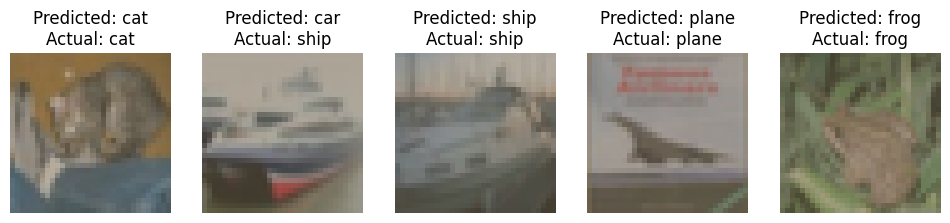

In [47]:
print("\nVisualizing Simple Feed Forward Model Results:")
visualize_model_results(ffn_model, testloader, class_names)

- Visualize the results for the CNN model


Visualizing CNN Model Results:


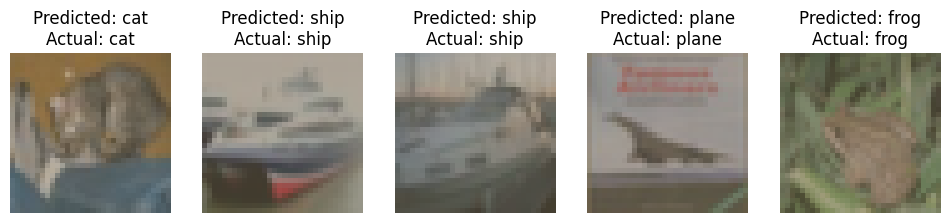

In [39]:
print("\nVisualizing CNN Model Results:")
visualize_model_results(cnn_model, testloader, class_names)

- Visualize the results for the ResNet model


Visualizing ResNet Model Results:


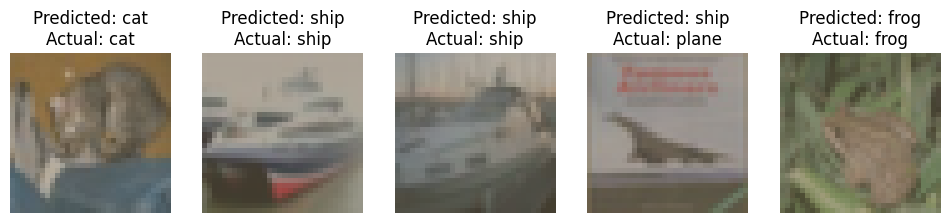

In [40]:
print("\nVisualizing ResNet Model Results:")
visualize_model_results(resnet_model, testloader, class_names)

# Comparing the Result

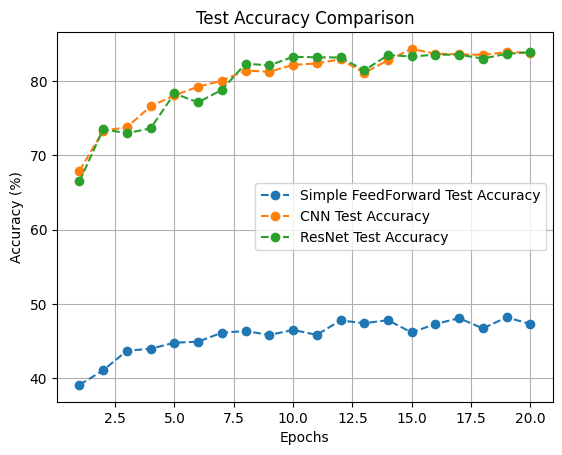

In [35]:
# Plot the accuracy comparisons between the three models
epochs = range(1, 21)

plt.plot(epochs, ffn_test_acc, label='Simple FeedForward Test Accuracy', linestyle='--', marker='o')
plt.plot(epochs, cnn_test_acc, label='CNN Test Accuracy', linestyle='--', marker='o')
plt.plot(epochs, resnet_test_acc, label='ResNet Test Accuracy', linestyle='--', marker='o')

plt.title('Test Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()